# Limit order book simulation

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. In this notebook, we'll look at an example market simulation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

**Write out master equations for the LOB models explicitly!!!**

Begin with an **individual-agent** version of the **Santa Fe model** using a synchronous ensemble rejection algorithm. The key point here is to make sure the overall holding rate is large enough which should limit the number of anachronisms in the order flow...

In [184]:
class SFagentens:
    
    def __init__(self, setup : dict):
        """
        A class for an ensemble of agents which
        can be evolved in time.
        
        Args:
        setup
            A dictionary of setup parameters.
        
        """
        self.setup = setup
        
        # Setup the bid and ask decision properties
        self.bids = np.zeros(
            (self.setup["Nlattice"], self.setup["Nagents"]), 
            dtype=int,
        )
        self.asks = np.zeros(
            (self.setup["Nlattice"], self.setup["Nagents"]), 
            dtype=int,
        )
        
        # Keep a memory of all outstanding limit orders,
        # their volumes and which agent they are associated to
        self.membidLOs = np.zeros(
            (self.setup["Nlattice"], self.setup["Nagents"]),
            dtype=int,
        )
        self.memaskLOs = np.zeros(
            (self.setup["Nlattice"], self.setup["Nagents"]),
            dtype=int,
        )
        
    def iterate(self, market_state_info : dict):
        """
        Iterate the ensemble a step forward in time by
        asking each agent to make buy-sell-cancel-hold decisions.
        
        Args:
        market_state_info
            A dictionary of current market state info.
            
        """
        # Sum over past limit orders by agent
        summembidLOs = np.sum(self.membidLOs, axis=0)
        summemaskLOs = np.sum(self.memaskLOs, axis=0)
        
        # Consistent event rate computations
        self.tau = np.random.exponential(1.0 / self.setup["HOrate"])
        HOr, LOr, MOr, COr = (
            self.tau * np.ones(self.setup["Nagents"]),
            self.setup["LOrateperagent"] * np.ones(
                self.setup["Nagents"]
            ),
            self.setup["MOrateperagent"] * np.ones(
                self.setup["Nagents"]
            ),
            (
                (summembidLOs + summemaskLOs)
                * self.setup["COrateperagent"]
            ),
        )
        totr = HOr + LOr + MOr + COr
        
        # Draw events from the uniform distribution
        # and apply the rejection inequalities to
        # assign the agents' decisions
        evs = np.random.uniform(size=self.setup["Nagents"])
        LOs = (evs < LOr / totr)
        MOs = (LOr / totr <= evs) & (evs < (LOr + MOr) / totr)
        COs = (
            ((LOr + MOr) / totr <= evs)
            & (evs < (LOr + MOr + COr) / totr)
        )
        
        # Decide on the prices for both the limit orders
        # and the order cancellations
        boa = (
            np.random.binomial(1, 0.5, size=self.setup["Nagents"]) 
            == 1
        )
        prs = np.random.uniform(
            size=(self.setup["Nlattice"], self.setup["Nagents"])
        )
        dec = np.exp(
            - np.abs(
                market_state_info["midprice"]
                - market_state_info["prices"]
            ) * self.setup["LOdecay"]
        )
        LObpts = np.random.choice(
            np.arange(0, market_state_info["bidpt"], 1, dtype=int),
            size=self.setup["Nagents"],
            p=(
                dec[:market_state_info["bidpt"]]
                / np.sum(dec[:market_state_info["bidpt"]])
            ),
        )
        LOapts = np.random.choice(
            np.arange(
                market_state_info["askpt"], 
                self.setup["Nlattice"], 
                1, 
                dtype=int,
            ),
            size=self.setup["Nagents"],
            p=(
                dec[market_state_info["askpt"]:]
                / np.sum(dec[market_state_info["askpt"]:])
            ),
        )
        CObpts = np.argmax(
            (
                prs
                * ((self.membidLOs + self.memaskLOs) > 0)
                * boa
            ), 
            axis=0,
        )
        COapts = np.argmax(
            (
                prs
                * ((self.membidLOs + self.memaskLOs) > 0)
                * (boa==False)
            ), 
            axis=0,
        )
        
        # Pass the limit-order and market-order decisions 
        # on to the output properties while leaving some 
        # market orders unfulfilled if there are too many 
        # of them
        self.bids[:], self.asks[:] = 0, 0
        self.bids[
            (
                LObpts[boa & LOs], 
                np.arange(0, self.setup["Nagents"], 1, dtype=int)[
                    boa & LOs
                ],
            )
        ] += 1
        self.asks[
            (
                LOapts[(boa==False) & LOs], 
                np.arange(0, self.setup["Nagents"], 1, dtype=int)[
                    (boa==False) & LOs
                ],
            )
        ] += 1
        agbmos = np.arange(0, self.setup["Nagents"], 1, dtype=int)[
            boa & MOs
        ]
        agamos = np.arange(0, self.setup["Nagents"], 1, dtype=int)[
            (boa==False) & MOs
        ]
        namos = np.sum(self.memaskLOs[market_state_info["askpt"]])
        nbmos = np.sum(self.membidLOs[market_state_info["bidpt"]])
        self.bids[
            market_state_info["askpt"], 
            np.random.choice(
                agbmos, 
                size=(
                    namos * (len(agbmos) > namos) 
                    + len(agbmos) * (len(agbmos) <= namos)
                ), 
                replace=False,
            ),
        ] += 1
        self.asks[
            market_state_info["bidpt"], 
            np.random.choice(
                agamos, 
                size=(
                    nbmos * (len(agamos) > nbmos) 
                    + len(agamos) * (len(agamos) <= nbmos)
                ), 
                replace=False,
            ),
        ] += 1
        
        # Pass the cancel-order decisions on to the output
        # properties if they haven't already been fulfilled
        diff = np.sum(
            self.membidLOs + self.bids - self.memaskLOs - self.asks, 
            axis=1,
        )
        cbids = np.zeros(
            (self.setup["Nlattice"], self.setup["Nagents"]), 
        )
        casks = np.zeros(
            (self.setup["Nlattice"], self.setup["Nagents"]), 
        )
        cbids[
            (
                CObpts[COs & boa], 
                np.arange(0, self.setup["Nagents"], 1, dtype=int)[
                    COs & boa
                ],
            )
        ] += np.random.uniform(size=len(CObpts[COs & boa]))
        casks[
            (
                COapts[COs & (boa==False)], 
                np.arange(0, self.setup["Nagents"], 1, dtype=int)[
                    COs & (boa==False)
                ],
            )
        ] += np.random.uniform(size=len(COapts[COs & (boa==False)]))
        cbidssinds = np.argsort(cbids, axis=1)
        caskssinds = np.argsort(casks, axis=1)
        cbput = 0 + 1 * (
            np.tensordot(
                self.setup["Nlattice"] - np.minimum(
                    np.sum(cbids > 0, axis=1), 
                    diff * (diff > 0),
                ),
                np.ones(self.setup["Nagents"]),
                axes=0,
            ) <= np.tensordot(
                np.ones(self.setup["Nlattice"]),
                np.arange(0, self.setup["Nagents"], 1),
                axes=0,
            )
        )
        caput = 0 + 1 * (
            np.tensordot(
                self.setup["Nlattice"] - np.minimum(
                    np.sum(casks > 0, axis=1), 
                    - diff * (diff < 0),
                ),
                np.ones(self.setup["Nagents"]),
                axes=0,
            ) <= np.tensordot(
                np.ones(self.setup["Nlattice"]),
                np.arange(0, self.setup["Nagents"], 1),
                axes=0,
            )
        )
        np.put_along_axis(cbids, cbidssinds, cbput, axis=1)
        np.put_along_axis(casks, caskssinds, caput, axis=1)
        self.bids -= cbids.astype(int)
        self.asks -= casks.astype(int)
        
        # Update the agent-specific limit order memory
        self.membidLOs += self.bids
        self.memaskLOs += self.asks

In [185]:
class LOBsim:
    
    def __init__(self, setup : dict):
        """
        A class for simulated limit order books
        which can be evolved in time.
        
        Args:
        setup
            A dictionary of setup parameters.
        
        """
        self.setup = setup
        self.time = 0.0
        self._ae = None
        
        # Setup the LOB prices and the market order integer ticks
        self.prices = np.arange(
            self.setup["tickscale"], 
            (float(self.setup["Nlattice"]) * self.setup["tickscale"])
            + self.setup["tickscale"], 
            self.setup["tickscale"],
        )
        self.market_state_info = {
            "bidpt" : self.setup["initbidpricetick"],
            "askpt" : self.setup["initaskpricetick"],
            "midprice" : (
                self.prices[self.setup["initaskpricetick"]] 
                + self.prices[self.setup["initbidpricetick"]]
            ) / 2.0,
            "prices" : self.prices,
        }
        self.bids = np.zeros(self.setup["Nlattice"], dtype=int)
        self.asks = np.zeros(self.setup["Nlattice"], dtype=int)
        
    @property
    def ae(self):
        if self._ae is None:
            self._ae = SFagentens(self.setup)
        return self._ae
    
    def annihilate_and_update(self):
        """Apply the annihilation of overlapping bid 
        and ask prices. Also recalculate the mid prices."""
        
        # Annihilate the overlapping orders by taking the difference
        diff = self.asks - self.bids
        self.asks = diff * (diff>0.0)
        self.bids = - diff * (diff<0.0)
        
        # Recalculate the bid-ask spread and mid price
        self.market_state_info["askpt"] = np.min(
            np.nonzero(self.asks)
        )
        self.market_state_info["bidpt"] = np.max(
            np.nonzero(self.bids)
        )
        self.market_state_info["midprice"] = (
            self.prices[self.market_state_info["askpt"]] 
            + self.prices[self.market_state_info["bidpt"]]
        ) / 2.0
        
    def iterate(self):
        """Iterate the book volumes (and the ensemble of agents) 
        a step forward in time."""
        
        # Iterate the agent ensemble
        self.ae.iterate(self.market_state_info)
        
        # Apply the agent orders to the book
        self.time += self.ae.tau
        self.bids += np.sum(self.ae.bids, axis=1)
        self.asks += np.sum(self.ae.asks, axis=1)
        if (np.any(self.bids<0) | np.any(self.asks<0)):
            print('Problem!')
        
        # Annihilate any outstanding orders and 
        # recalculate the spread
        self.annihilate_and_update()

In [192]:
setup = {
    # Number of agents
    "Nagents" : 100,
    # Limit order rate per agent
    "LOrateperagent" : 1.0,
    # Market order rate per agent
    "MOrateperagent" : 0.5,
    # Cancel order rate per agent
    "COrateperagent" : 0.01,
    # The overall holding rate
    "HOrate" : 50.0,
    # Limit order decay power in price units
    "LOdecay" : 0.05,
    # Initial bid tick
    "initbidpricetick" : 49,
    # Initial ask tick
    "initaskpricetick" : 51,
    # The price tick size
    "tickscale" : 1.0,
    # The number of price points simulated
    "Nlattice" : 100,
}

# Initialise the LOB simulation
los = LOBsim(setup)

# Iterate the LOB over time
tend, t = 10.0, 0.0
midps = []
while t < tend:
    los.iterate()
    t = los.time
    midps.append([t, los.market_state_info["midprice"]])

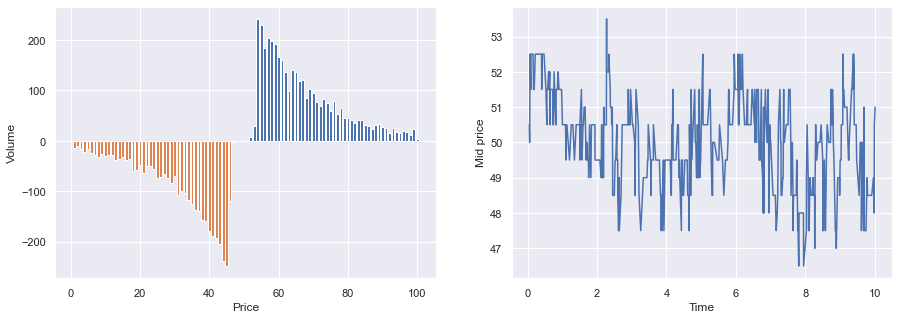

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(los.prices, los.asks)
ax[0].bar(los.prices, -los.bids)
ax[1].plot(np.asarray(midps)[:, 0], np.asarray(midps)[:, 1])
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
ax[1].set_ylabel('Mid price')
ax[1].set_xlabel('Time')
plt.show()